# 🔍 Uncertainty Evaluation in Crime Forecasting with Conformal Prediction Intervals

This notebook presents a complete evaluation pipeline for uncertainty-aware crime forecasting using **Conformal Prediction (CP)**. A simple cell-based model (`NaivePerCellModel`) is used as the predictive base, and CP is applied to generate **per-cell, per-day prediction intervals**. These intervals are analyzed both globally and in spatial-temporal dimensions.

## 🎯 Objectives of the Analysis

- Generate calibrated prediction intervals for daily crime counts at the grid-cell level.
- Evaluate core uncertainty metrics:
  - **Empirical Coverage**
  - **Mean Interval Width**
  - **Winkler Score (MWI)**
  - **Distance to Interval when Missed**
  - **Coverage Width-Based Criterion (CWC)**
- Analyze the behavior of these metrics across different dimensions:
  1. **Global**: overall model performance.
  2. **Spatial**: variation across geographic units.
  3. **Temporal**: evolution of metrics over time.
  4. **Hotspot Type**: stratified analysis based on alignment between predicted and actual hotspots.

## ⚙️ Notebook Structure

1. **Configuration and Data Loading**: Includes global parameters, input data, and beat-level geometries.
2. **Conformal Prediction Application**: Generates lower/upper bounds and point estimates for each cell.
3. **Global and Spatial Evaluation**: Summary statistics and visualizations of uncertainty metrics.
4. **Hotspot-Type Analysis**:
   - **Static**: based on cumulative behavior across time.
   - **Dynamic**: day-by-day classification of match types.
5. **Error Analysis and Bivariate Plots**: Understands coverage failures and their spatial/metric context.

This analysis aims to characterize **how reliable** the model's predictions are, and **where and when** uncertainty is high—crucial for designing priority-based interventions in urban safety planning.

## 📦 Imports and Setup

This section initializes the working environment by importing required libraries and registering custom modules used throughout the notebook.

### 🔧 Standard and Geospatial Libraries

- `numpy`, `pandas`: for numerical and tabular data handling.
- `matplotlib.pyplot`, `seaborn`: for static and styled visualizations.
- `geopandas`: for handling spatial vector data.
- `joblib`: for efficient saving/loading of model objects.
- `warnings`: to suppress non-critical warnings during execution.
- `os`, `sys`, `pathlib`: for dynamic path resolution and OS compatibility.

### 🗂️ Project Root Configuration

To enable import of internal modules from the `src/` folder, the project root is dynamically added to the system path:


In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../../.."))
sys.path.insert(0, project_root)

# Load modules

from src.utils.data_partition import temporal_split
from src.conformal.mapie_per_cell import apply_conformal_mapie_per_cell

from src.utils.spatial_processing import predictions_to_grid, grid_to_dataframe
from src.evaluation.evaluation_cp import base_analysis
from src.evaluation.visualize_basic_analysis import plot_temporal_metrics_summary, plot_metric_radar_by_hotspot_type, plot_temporal_metrics_over_time

from src.utils.visualization import plot_geospatial_data_maps

import warnings
warnings.filterwarnings("ignore")

## ⚙️ Load Configuration, Data, and Model

This section prepares the data and environment for conformal prediction by:

- Loading configuration parameters
- Reading spatial and temporal data
- Loading a trained prediction model
- Performing data partitioning for calibration and testing

---

### 📄 Configuration

A global configuration file (`config.json`) is loaded, specifying:

- **Temporal partitioning**:
  - `train_months`, `calibration_months`, `test_months` → converted into days
- **Hotspot definition method**:
  - `"by_cells"` or `"by_crimes"` for identifying spatial units of interest
- **Hotspot percentage**:
  - Proportion of area or crime volume considered as hotspots


In [2]:
# Load global config
config_path = os.path.join("../../../", "config.json")
with open(config_path, 'r') as f:
    config = json.load(f)

# Define hotspot method from config
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
hotspot_method = config["evaluation"].get("hotspot_definition", "by_cells")  # default


# Partition data
partition_config = config["data_partition"]
days_per_month = 30
train_days = partition_config["train_months"] * days_per_month
calibration_days = partition_config["calibration_months"] * days_per_month
test_days = partition_config["test_months"] * days_per_month

# Paths
data_dir = "../../../data/real_data/Chicago/"
map_path = os.path.join(data_dir, "beat_to_coord_map.json")

path_dir="../../../results/models/real_data/Chicago/"
naive_model = joblib.load(os.path.join(path_dir,"naive_cell_model.pkl"))

# Define path
data_path = "../../../../../../uncertainty-informed-data/real_data/Chicago"
geometry_name = "police_beats.geojson"
geometry_path = os.path.join(data_path, geometry_name)

save_folder = Path("../../../results/figures/Chicago_jackknife")
os.makedirs(save_folder,exist_ok=True)

# Load data
gdf = gpd.read_file(os.path.abspath(geometry_path))

# Load
df=pd.read_csv(os.path.join(data_dir,"df_used.csv"))
with open(map_path) as f:
    beat_to_coord_map = json.load(f)

coord_to_beat_map = {tuple(v): k for k, v in beat_to_coord_map.items()}

rows, cols = tuple(df[["row","col"]].max()+1)
grid_size = (rows, cols)

df_train, df_calib, df_test = temporal_split(df, train_days, train_days + calibration_days, train_days + calibration_days + test_days)

# Define features
features = ["timestep", "row", "col"]
target = "count"

X_train, y_train = df_train[features].copy(), df_train[target].copy()

X_cal = df_calib[features].copy()
y_cal = df_calib[target].copy()

X_test = df_test[features].copy()
y_test = df_test[target].copy()

alpha = 0.1 ## significance level


# 📏 Apply Conformal Prediction (MAPIE) per Cell

We use **MAPIE** to compute conformal prediction intervals for crime count forecasts at the cell level using a naïve model trained on spatiotemporal features.

### ⚙️ Parameters

- **Base model**: `NaivePerCellModel` (already fitted)
- **Conformal method**: `"split"` → Inductive Conformal Prediction using a separate calibration set
- **Significance level (alpha)**: `0.1` → Target marginal coverage is 90%

The prediction returns three interval grids and the ground truth grid:

- 🔽 `y_min`: Lower bound of the interval  
- 🟢 `y_pred`: Point prediction (mean)  
- 🔼 `y_max`: Upper bound of the interval  
- 🎯 `grid_true`: Actual crime counts on the test set  

All lower bounds are **clipped to zero**, as negative crime values are not valid in this context.

---

## 🖼️ Visualizing Prediction Intervals

We visualize the output of the conformal prediction step for a randomly selected test day. The following spatial maps are rendered using the geometry of Chicago Police Beats:

- **Lower Bound** of the prediction interval  
- **Predicted Mean** crime count  
- **Upper Bound** of the interval  
- **Observed (Real) Crimes**  

All maps use a consistent color scale (`YlOrRd`) and spatial alignment for comparison. This helps assess the calibration and width of the uncertainty intervals in different regions of the city.

Processing rows: 100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


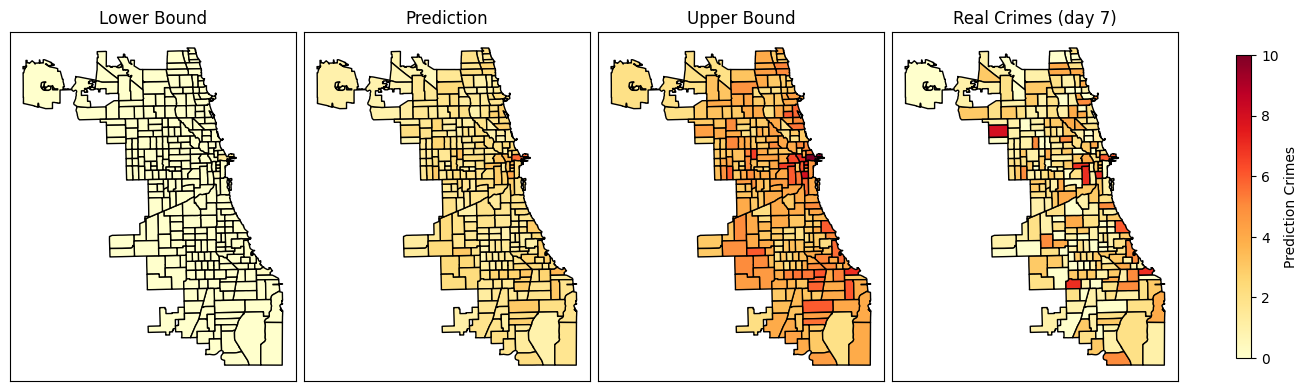

In [3]:
# Apply conformal prediction per cell using pre-trained model
grid_pred, y_min, y_max, grid_true = apply_conformal_mapie_per_cell(
    X_train, y_train,
    X_cal, y_cal,
    X_test, y_test,
    base_estimator=naive_model,
    alpha=alpha,
    conformalizer="jackknife",
    grid_size=grid_size
)

# Visualize prediction intervals for a random test day
pred_day = np.random.randint(0, test_days)

df_true = grid_to_dataframe(grid_true[pred_day], coord_to_beat_map, value_name="Real Crimes")
df_pred = grid_to_dataframe(grid_pred[pred_day], coord_to_beat_map, value_name="Prediction Crimes")
df_min = grid_to_dataframe(y_min[pred_day], coord_to_beat_map, value_name="Prediction Crimes")
df_max = grid_to_dataframe(y_max[pred_day], coord_to_beat_map, value_name="Prediction Crimes")

# Plot all in one layout
plot_geospatial_data_maps(
    gdf[["beat_num", "geometry"]],
    [df_min, df_pred, df_max, df_true],
    titles=["Lower Bound", "Prediction", "Upper Bound", f"Real Crimes (day {pred_day})"],
    columns=["Prediction Crimes", "Prediction Crimes", "Prediction Crimes", "Real Crimes"],
    cmap="YlOrRd",
    share_colorbar=True,
    edgecolor="black",
    figsize=(13, 4),
    save_path=save_folder / "predictions_intervals.pdf"
)

# 📊 Run Full Evaluation and Hotspot Classification

We apply a comprehensive analysis pipeline that evaluates the **quality of prediction intervals** and identifies **hotspot regions** under uncertainty.

The function `base_analysis(...)` performs the following:

---

## 🧪 Evaluation Metrics

For each cell and time step:
- ✅ `in_interval`: Boolean array indicating whether the real value is within the predicted interval.
- 📏 `widths`: Interval widths (`y_max - y_min`) as a measure of uncertainty.
- 🔺 `error`: Distance between the ground truth and the prediction interval when the interval **fails to cover** the true value.

These arrays retain the full spatiotemporal structure.

---

## 🔥 Hotspot Classification

Two levels of hotspot cell classification are generated:

- **`overall_hs_class_grid`**: Classification of cells across **all timesteps**, using either:
  - `by_cells`: top-k most active cells overall, or
  - `by_crimes`: cells contributing most to the overall count.
  
- **`time_step_hs_class_grid`**: Classification **per timestep**, allowing dynamic hotspot identification.

Each cell is labeled as:
- `"Both"` (true hotspot & predicted as hotspot)
- `"GT-only"` (missed hotspot)
- `"Pred-only"` (false alarm)
- `"Neither"` (non-hotspot)

---

## 📈 Metric Aggregation

From the raw spatiotemporal arrays, we compute summary **metrics per cell type** and **per timestep**:

- 🔹 `result_cwc`: Coverage Width-Based Criterion (CWC)  
- 📐 `result_mwi`: Mean Winkler Interval Score  
- ✅ `coverage_results`: Coverage score by group and time  
- 📏 `width_results`: Mean interval width by group and time  
- 🚫 `error_results`: Mean error (when outside interval)  
- 📊 `y_true_results` and `y_pred_results`: Mean observed and predicted values by group and time

These are structured as dictionaries:
- `"static_group"`: Aggregated by overall hotspot type  
- `"dynamic_group"`: Aggregated by timestep-based classification  
- `"per_time"`: Overall average per timestep  
- `"static_group_time"` and `"dynamic_group_time"`: Breakdown by group and timestep

This output feeds into subsequent visualizations of radar plots, temporal evolution, and calibration diagnostics.

In [4]:
(
    in_interval,
    widths,
    error,
    overall_hs_class_grid,
    time_step_hs_class_grid,
    result_cwc,
    result_mwi,
    coverage_results,
    width_results,
    error_results,
    y_true_results,
    y_pred_results
) = base_analysis(y_min, y_max, grid_pred, grid_true, grid_size, alpha, hotspot_percentage, eta=8, ref=7)

# 📊 Overall Performance Metrics

This section summarizes the **global performance** of the prediction intervals across all cells and timesteps, regardless of their hotspot classification.

The following metrics are reported:

- 🎯 **Coverage Width-Based Criterion (CWC)**  
  A compound metric that penalizes low coverage and wide intervals. Lower is better.

- 📐 **Mean Winkler Interval Score (MWI)**  
  A proper scoring rule for evaluating interval predictions. Combines sharpness and calibration. Lower is better.

- ✅ **Coverage Score**  
  Proportion of true values covered by the prediction interval. Target coverage is typically 90%. The standard deviation of binary coverage is also reported.

- 📏 **Mean Interval Width**  
  Average width of the prediction intervals. Smaller values suggest sharper (more confident) predictions. A standard deviation is included.

- 🚫 **Distance to Interval (When Not Covered)**  
  When a true value falls **outside** its predicted interval, this metric captures how far it is from the closest bound. Helps characterize under/over-confidence. The standard deviation accounts for variability in extreme errors.

These metrics offer a holistic view of model calibration, sharpness, and reliability across the entire spatiotemporal grid.

In [5]:
print("Overall Metrics:")
print(f"Coverage Width-Based Criterion: {result_cwc['global']:.2f}")
print(f"Mean Winkler Interval Score: {result_mwi['global']:.2f}" )
print(f"Coverage Score: {coverage_results['global']*100:.2f}% ± {in_interval.std()*100:.2f}%")
print(f"Mean Width Score: {width_results['global']:.2f} ± {widths.std():.2f}")
print(f"Distance to Interval (when no cover): {error_results['global']:.2f} ± {np.nanstd(error):.2f}")

Overall Metrics:
Coverage Width-Based Criterion: 0.49
Mean Winkler Interval Score: 5.01
Coverage Score: 93.82% ± 24.08%
Mean Width Score: 3.53 ± 1.44
Distance to Interval (when no cover): 1.20 ± 0.88


# 📈 Temporal Summary of Global Metrics

This section visualizes how **uncertainty metrics** evolve over time across the entire grid, without distinguishing between hotspot types.

The following metrics are plotted over the test period:

1. 🟦 **Coverage Width-Based Criterion (CWC)**  
   Penalizes both large interval widths and low coverage. It provides a joint measure of uncertainty quality.

2. ✅ **Coverage Score (%)**  
   Shows the percentage of predictions that fall within the conformal prediction intervals at each timestep. A well-calibrated model should maintain coverage close to the nominal level (e.g., 90%).

3. 📏 **Average Interval Width**  
   Measures the average size of the prediction intervals at each timestep. Ideally, intervals are narrow (sharp) while still maintaining good coverage.

4. 📊 **Mean Winkler Interval Score (MWI)**  
   A proper scoring rule that jointly evaluates calibration and sharpness.

5. 📉 **Distance to Interval (When Missed)**  
   Quantifies how far the true value falls outside the predicted interval when it is **not covered**. Helps to assess the severity of coverage failures.

6. 📊 **Real and Predicted Crime Count**  
   Compares the total predicted crime count and the real crime count at each timestep. Includes prediction intervals (min/max) to reflect uncertainty around the total.

Each subplot allows identifying temporal patterns in the reliability and sharpness of predictions. This is particularly useful to detect degradation over time or underperformance in specific temporal windows.

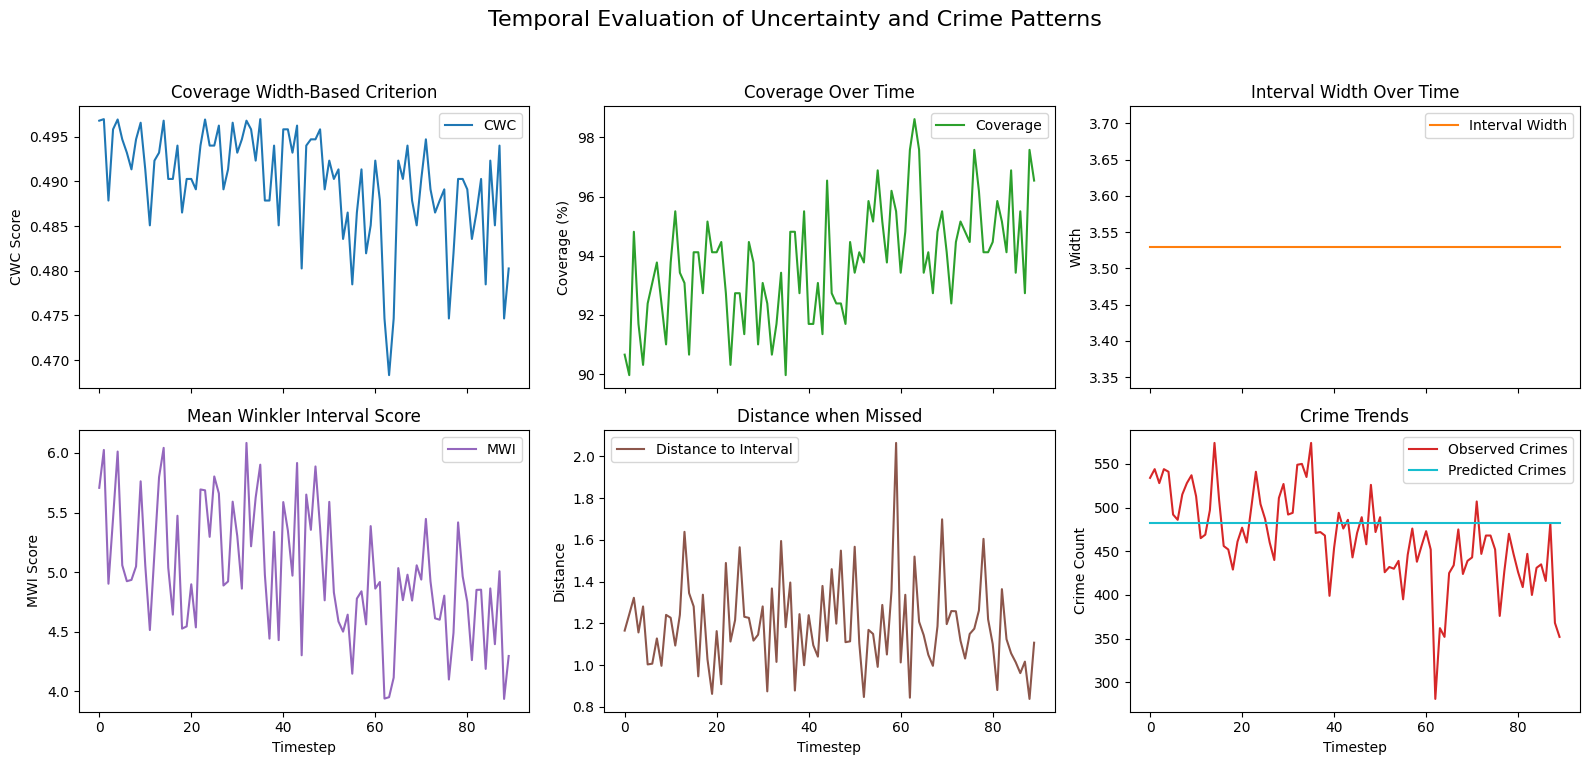

Pearson Correlation with Total Observed Crimes:
CWC Score               : ρ = 0.808
Coverage (%)            : ρ = -0.824
Interval Width          : ρ = nan
MWI                     : ρ = 0.773
Distance when Missed    : ρ = 0.200
Predicted Crime Count   : ρ = nan

##################################################
Time Series Metrics (Mean ± Std):
CWC                     : 0.49 ± 0.01
MWI                     : 5.01 ± 0.54
Coverage (%)            : 93.82% ± 1.90%
Interval Width          : 3.53 ± 0.00
Distance when Missed    : 1.19 ± 0.21
Observed Crimes         : 466.32 ± 51.65
Predicted Crimes        : 482.53 ± 0.00


In [6]:
plot_temporal_metrics_summary(
    result_cwc,
    coverage_results,
    width_results,
    result_mwi,
    error_results,
    y_true_results,
    y_pred_results,
    save_path= save_folder / "overall_temporal_eval.pdf"
)


# 🗺️ Spatial Evaluation of Predictive Uncertainty

This section analyzes the spatial distribution of uncertainty metrics across the prediction grid, providing a **per-cell evaluation**. It allows identifying areas where the model performs better or worse in terms of uncertainty estimation.

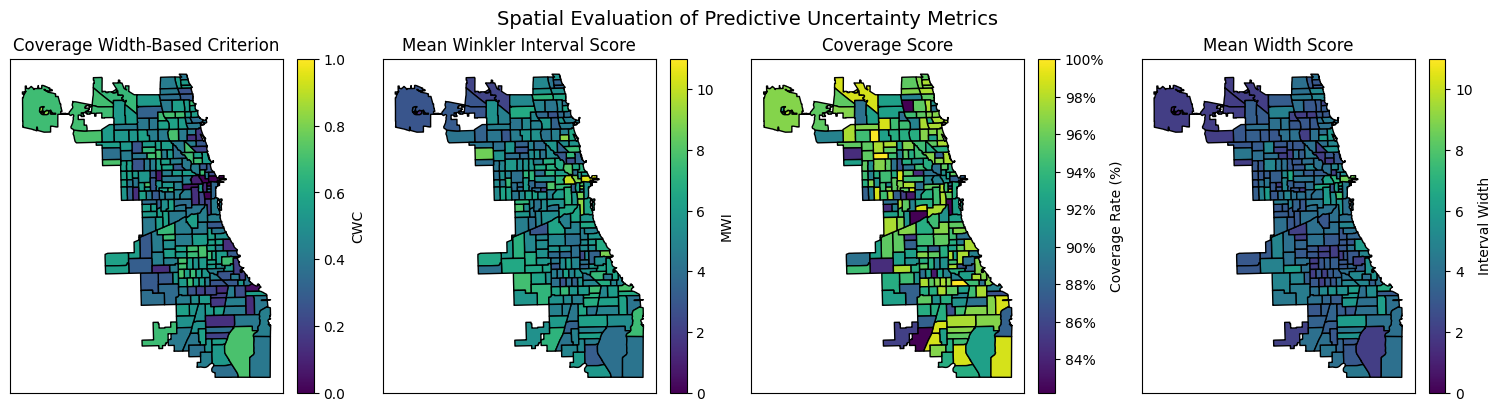

Average Coverage Width-Based Criterion: 0.48 ± 0.19
Average per-cell Mean Winkler Interval Score: 5.01 ± 1.85
Average Coverage Score: 93.82% ± 4.02%
Average Mean Width Score: 3.53 ± 1.44
Average Distance to Interval: 1.24 ± 0.53


In [7]:
df_CWS=grid_to_dataframe(result_cwc["per_cell"], coord_to_beat_map, value_name="Coverage Width-Based Criterion").set_index(["row","col","beat"])
CWS_average, CWS_std = result_cwc["per_cell"].mean(), result_cwc["per_cell"].std()

df_MWI=grid_to_dataframe(result_mwi["per_cell"], coord_to_beat_map, value_name="Mean Winkler Interval Score").set_index(["row","col","beat"])
MWI_average, MWI_std = result_mwi["per_cell"].mean(), result_mwi["per_cell"].std()

df_coverage_score=grid_to_dataframe(coverage_results["per_cell"], coord_to_beat_map, value_name="Coverage Score").set_index(["row","col","beat"])
coverage_average, coverage_std = coverage_results["per_cell"].mean()*100, coverage_results["per_cell"].std()*100
df_coverage_score["Coverage Score"]*=100

df_width=grid_to_dataframe(width_results["per_cell"], coord_to_beat_map, value_name="Mean Width Score").set_index(["row","col","beat"])
width_average, width_std = width_results["per_cell"].mean(), width_results["per_cell"].std()

distance_interval_average, distance_interval_std = np.nanmean(error_results["per_cell"]), np.nanstd(error_results["per_cell"])


plot_geospatial_data_maps(
    gdf_base=gdf[["beat_num", "geometry"]],
    df_list=[df_CWS, df_MWI, df_coverage_score, df_width],
    columns=["Coverage Width-Based Criterion", "Mean Winkler Interval Score","Coverage Score","Mean Width Score"],
    titles=["Coverage Width-Based Criterion", "Mean Winkler Interval Score", "Coverage Score","Mean Width Score"],
    cmap="viridis",
    share_colorbar=False,
    colorbar_labels=["CWC","MWI","Coverage Rate (%)", "Interval Width"],
    suptitle="Spatial Evaluation of Predictive Uncertainty Metrics",
    figsize=(15, 4),
    percent_format=[False,False,True,False],
    vmax=[1, 11, 100, 11],
    vmin=[0, 0, None, 0],
    save_path= save_folder / "overall_spatial_eval.pdf"
)


print(f"Average Coverage Width-Based Criterion: { CWS_average :.2f} ± {CWS_std:.2f}")
print(f"Average per-cell Mean Winkler Interval Score: { MWI_average :.2f} ± {MWI_std:.2f}")
print(f"Average Coverage Score: { coverage_average :.2f}% ± {coverage_std:.2f}%")   
print(f"Average Mean Width Score: { width_average :.2f} ± {width_std:.2f}")
print(f"Average Distance to Interval: {distance_interval_average:.2f} ± {distance_interval_std:.2f}")

# ❌ Analysis of Interval Failures: Width vs. Coverage Score

This section explores the relationship between **interval width** and **coverage score** specifically for the subset of grid cells and timesteps where the prediction interval failed to cover the true value (i.e., `Coverage = No`).

### 🧪 Data Preparation

We construct a DataFrame `df_metrics` that combines the following information per cell and timestep:

- ✅ **Coverage** status (Yes/No)
- 📏 **Interval Width**
- 📐 **Distance to Interval** (if not covered)
- 📊 **Coverage Score** (aggregated per cell)
- 🎯 **Mean Winkler Interval Score (MWI)**
- ⚖️ **Coverage Width-Based Criterion (CWC)**

Only rows where the coverage failed (`Coverage == No`) are selected for the plot.

### 📈 Visualization

A **hexbin jointplot** is used to visualize the relationship between:

- **X-axis**: Coverage Score (%) — per-cell average across time
- **Y-axis**: Interval Width — at the specific timestep and cell where failure occurred

This plot helps to answer:

- Do cells that tend to underperform in overall coverage also have **larger intervals** at failure?
- Are wider intervals failing less often (or more often)?

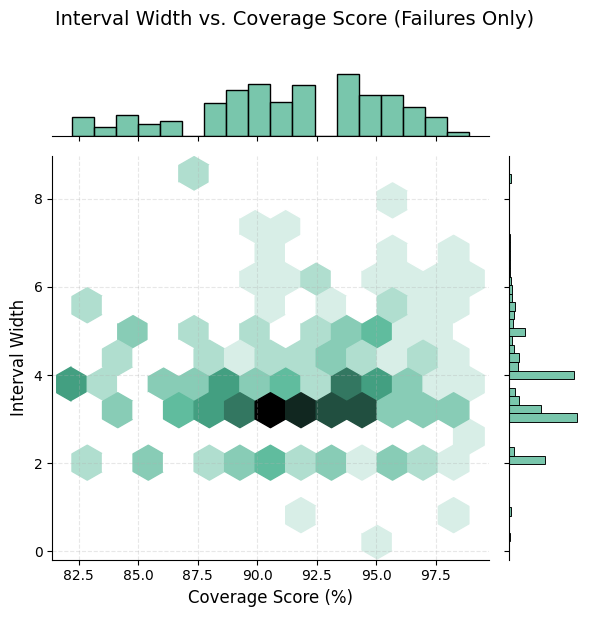

In [8]:
df_metrics = []

for metric_name, metric_data in zip(
    ["Coverage", "Width", "Distance to interval"],
    [in_interval, widths, error]
):
    df_metrics.append(grid_to_dataframe(metric_data, 
                                       coord_to_beat_map, 
                                       value_name=metric_name).set_index(["timestep","row","col","beat"]))

df_metrics = pd.concat(df_metrics,axis=1).reset_index()
df_metrics = df_metrics.merge(pd.concat([df_coverage_score, df_MWI, df_CWS],axis=1).reset_index())
df_metrics.replace({True:"Yes",False:"No"},inplace=True)

df_plot = df_metrics[df_metrics["Coverage"] == "No"].copy()
df_plot["Coverage Score (%)"] = df_plot["Coverage Score"]

# Ajustes del jointplot
joint_kws = dict(gridsize=13, bins=10)
g = sns.jointplot(
    data=df_plot,
    x="Coverage Score (%)",
    y="Width",
    kind="hex",
    joint_kws=joint_kws,
    color="#4CB391"
)

g.figure.suptitle("Interval Width vs. Coverage Score (Failures Only)", fontsize=14, y=1.02)
g.set_axis_labels("Coverage Score (%)", "Interval Width", fontsize=12)
g.ax_joint.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# 📊 Interval Width vs. Coverage Score: KDE Comparison

This plot visualizes the joint distribution of **interval width** and **coverage score**, highlighting differences between **covered** and **missed** predictions.

### 🧪 Input Data

We use the complete dataset of timesteps and cells (`df_metrics`) and filter out any entries without beat information. Each row includes:

- 📏 Interval Width (at each timestep and cell)
- 📊 Coverage Score (per cell, aggregated)
- ✅ Coverage outcome (`Yes` or `No`)

### 📈 KDE Joint Plot

A **Kernel Density Estimation (KDE)** joint plot is used to visualize the distribution of:

- **X-axis**: Interval Width
- **Y-axis**: Coverage Score (%)

With the following customizations:

- 🎨 **Hue** = Coverage (Yes / No), using a custom palette
- ⚙️ Separate density normalization per group (`common_norm=False`)
- 🔍 Contours (`levels=10`) without filled density (`fill=False`)
- 📊 Marginal histograms show distributions along each axis
- 🧭 Percentage formatter for the Y-axis
- 🧩 Legend moved inside the joint area for clarity

### 🔍 Interpretation

This visualization allows us to answer:

- How do the distributions of width and coverage differ between covered vs. missed predictions?
- Are miscoverages associated with **lower coverage scores** and **narrower intervals**?

### 🖼️ Visual Style

- Hue colors: Blue for `Yes`, Red for `No`
- Transparency (`alpha=0.4`) and thresholding improve legibility
- Axes are clearly labeled, and the title is centered above the plot

This diagnostic supports deeper understanding of the tradeoff between **interval width** and **coverage reliability** across the spatial-temporal grid.

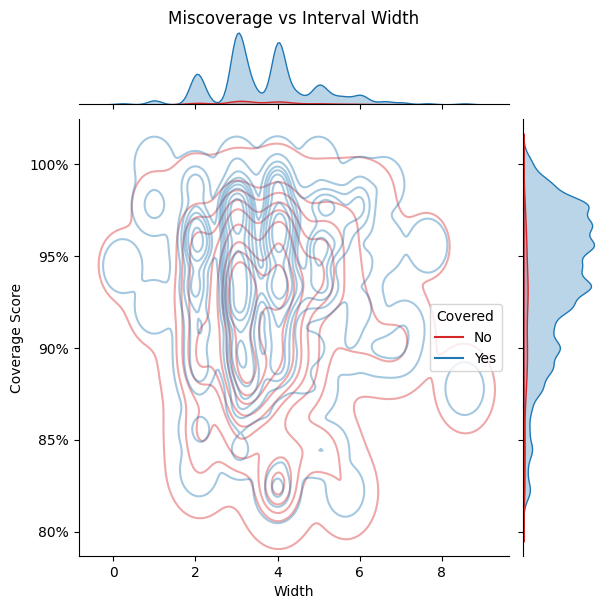

In [9]:
from matplotlib.ticker import PercentFormatter

palette = {
    "Yes": "#1f77b4",  
    "No": "#d62728"  
}

g = sns.jointplot(
    data=df_metrics.dropna(subset="beat"),
    x="Width",
    y="Coverage Score",
    hue="Coverage",
    kind="kde",
    palette=palette,
    fill=False,
    thresh=0.005,
    levels=10,
    common_norm=False,
    marginal_kws=dict(fill=True, alpha=0.3),
    joint_kws=dict(alpha=0.4)
)


g.ax_joint.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

plt.title("Miscoverage vs Interval Width", y=1.2)
sns.move_legend(g.ax_joint, "center right", title='Covered')

plt.tight_layout()
plt.show()


# 🔍 Overall Hotspot-Based Evaluation

In this section, we analyze uncertainty metrics based on a **temporal aggregation** of hotspot behavior across the entire test period.

### 🧭 Hotspot Classification (Cumulative)

Each cell is categorized according to its participation in predicted and ground-truth hotspot regions, accumulated over all timesteps:

- 🟦 `Neither`: The cell was never predicted nor observed as a hotspot.
- 🟢 `Both`: The cell was consistently predicted and matched ground-truth hotspot status.
- 🟣 `Pred-only`: The cell was predicted as a hotspot but never matched the ground truth.
- 🔴 `GT-only`: The cell belonged to the ground truth hotspot but was never predicted.

These labels are derived from the `overall_hs_class_grid`, which summarizes cell behavior throughout the evaluation period.

### 📊 Cell Count per Hotspot Type

We compute the number of cells in each category using `np.unique`. The result gives a sense of how well the model aligns with the real distribution of hotspots over time.

This classification will serve as a **grouping variable** in the following analyses, where we explore the spatial distribution and average behavior of uncertainty metrics such as:

- **Coverage Score**
- **Mean Interval Width**
- **Mean Winkler Interval Score**
- **Distance to Interval (when prediction fails)**
- **Coverage Width-Based Criterion (CWC)**

By comparing metrics across these groups, we can assess how uncertainty behaves under correct, missed, and false hotspot predictions, offering insights into model reliability and decision-support potential.

In [10]:
palette = {
    "Neither": "#1f77b4",
    "Both": "#2ca02c",
    "Pred-only": "#9467bd",
    "GT-only": "#d62728"
}

unique, counts = np.unique(overall_hs_class_grid, return_counts=True)
pd.DataFrame( {"Cell Type": unique,"Counts":counts})

,Cell Type,Counts
0,Both,43
1,GT-only,8
2,Neither,229
3,Pred-only,9


## 🗺️ Spatial Map of Hotspot Classification (Static)

We visualize the **spatial distribution of hotspot cell types** accumulated across the entire test period. This classification is static in the sense that each cell is assigned a single label based on its overall behavior over time:

- **Neither** (`🟦`): The cell was never predicted as a hotspot nor was part of the ground truth.
- **Both** (`🟢`): The cell was consistently predicted and matched the true hotspot status.
- **Pred-only** (`🟣`): The cell was predicted as a hotspot but never belonged to the ground truth.
- **GT-only** (`🔴`): The cell was in the ground truth but was never predicted as a hotspot.

### 🧩 Construction:

1. The `overall_hs_class_grid` stores cell types by `(row, col)` location.
2. We map each grid cell back to its corresponding police beat using `coord_to_beat_map`.
3. The result is merged with the Chicago police beat geometries (`gdf`) to build a geospatial visualization.

Each cell is colored according to its class, using the following color palette:

| Label      | Color      |
|------------|------------|
| Neither    | Blue 🟦    |
| Both       | Green 🟢   |
| Pred-only  | Purple 🟣  |
| GT-only    | Red 🔴     |

This map provides an intuitive overview of the spatial agreement and disagreement between the predicted and actual hotspot regions, helping us identify regions of persistent underestimation or overprediction.

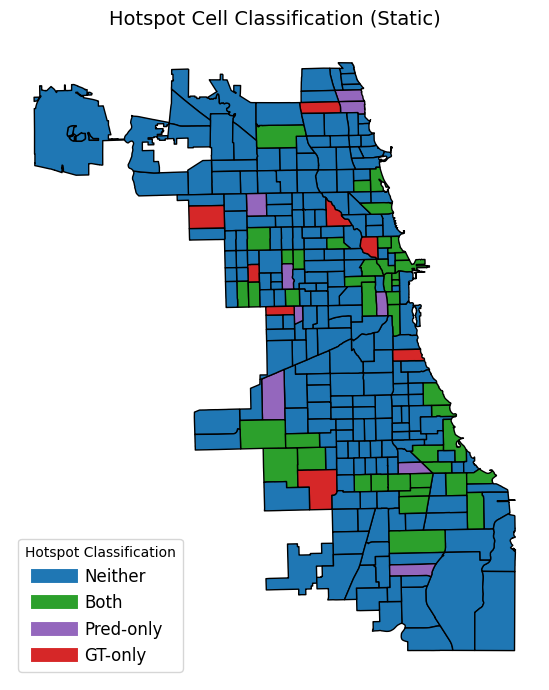

In [11]:
overall_hs_class_df = grid_to_dataframe(overall_hs_class_grid, coord_to_beat_map, value_name="cell_type").set_index(["row","col","beat"]).reset_index()
merged = gdf.merge(
    overall_hs_class_df,
    how="left",
    left_on="beat_num",
    right_on="beat"
).dropna(subset=["cell_type"])

merged["color"] = merged["cell_type"].map(palette)


fig, ax = plt.subplots(figsize=(7,7))
merged.plot(color=merged["color"], edgecolor="black", ax=ax)

for label, color in palette.items():
    ax.plot([], [], color=color, label=label, linewidth=10)
ax.legend(title="Hotspot Classification",  loc='lower left', frameon=True, fontsize=12)
ax.set_axis_off()
plt.title("Hotspot Cell Classification (Static)", fontsize=14)
plt.tight_layout()
plt.show()


## 🕸️ Radar Chart: Uncertainty Metrics by Hotspot Type (Static)

We generate radar plots to **compare uncertainty metrics across hotspot cell types** under a static classification (`overall_hs_class_grid`). This classification includes the following categories:

- **Both**: Cells correctly predicted as hotspots.
- **GT-only**: Missed true hotspots.
- **Pred-only**: False positives.
- **Neither**: Non-hotspot cells.

### 📊 Metrics Evaluated:

Each radar plot corresponds to one uncertainty metric. The metrics included are:

| Metric                                | Description                                                                 |
|---------------------------------------|-----------------------------------------------------------------------------|
| **Coverage Score**                    | Fraction of time the true count falls within the predicted interval         |
| **Interval Width Score**              | Average width of the prediction interval                                   |
| **Distance to interval when no cover**| Distance from the true value to the interval when it is not covered        |
| **Mean Winkler Interval Score**       | Penalty-based score combining width and miscoverage                        |
| **Coverage Width-Based Criterion (CWC)** | Composite metric penalizing low coverage and wide intervals              |

Each radar plot displays one line per cell type, helping to identify systematic differences in uncertainty quality between hotspot categories.

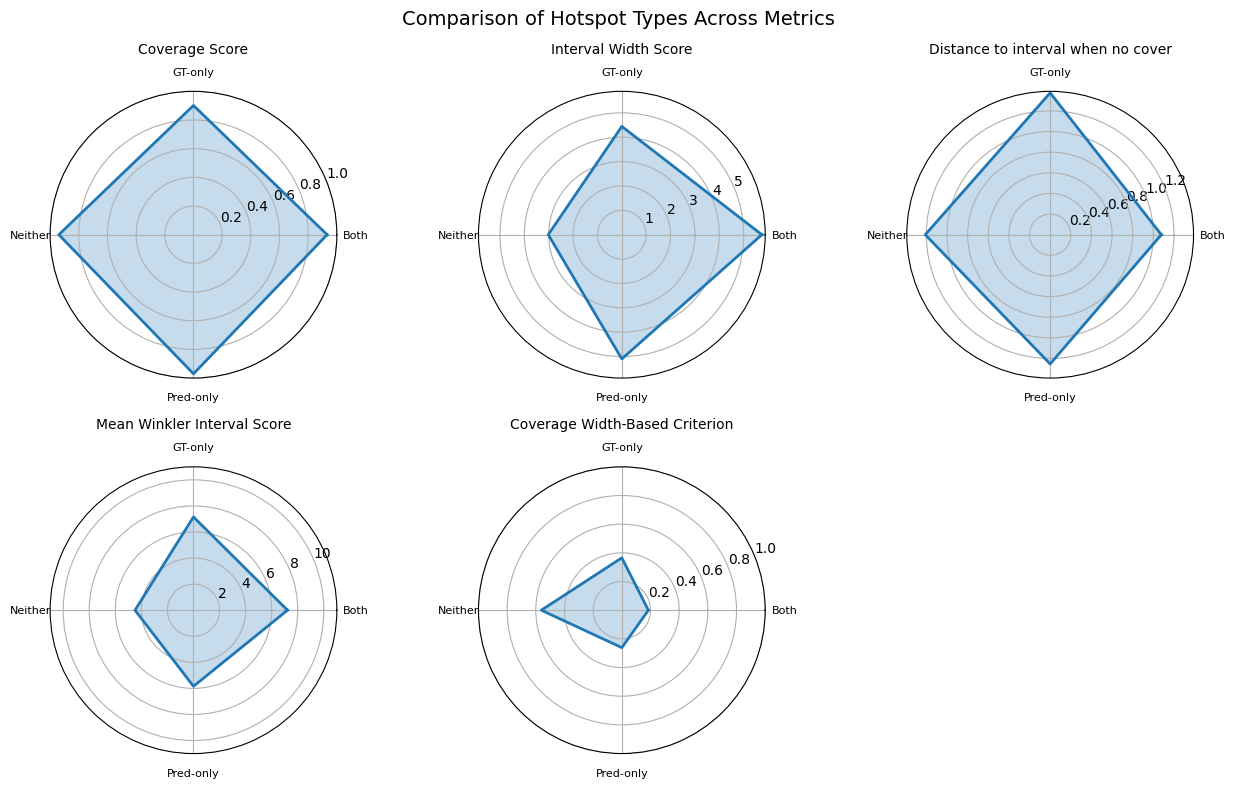

,Coverage Score,Interval Width Score,Distance to interval when no cover,Mean Winkler Interval Score,Coverage Width-Based Criterion
Both,0.932041,5.746675,1.077964,7.211814,0.185202
GT-only,0.901389,4.443665,1.374860,7.155196,0.365185
Neither,0.939350,3.019262,1.210797,4.487963,0.561676
Pred-only,0.970370,5.097664,1.252987,5.840174,0.261207


In [12]:
R=plot_metric_radar_by_hotspot_type(
    results_list=[coverage_results, width_results, error_results, result_mwi, result_cwc],
    metric_names=[
        "Coverage Score",
        "Interval Width Score",
        "Distance to interval when no cover",
        "Mean Winkler Interval Score",
        "Coverage Width-Based Criterion"
    ],
    static=True,  # or False
    title="Comparison of Hotspot Types Across Metrics",
    metric_limits={
        "Coverage Score": (0.0, 1.0),
        "Interval Width Score": (0.0, None),
        "Distance to interval when no cover": (0.0, None), 
        "Mean Winkler Interval Score": (0.0, 11.0),
        "Coverage Width-Based Criterion": (0.0, 1.0)},
    show_tables=True
)


## ⏳ Temporal Behavior of Uncertainty Metrics by Hotspot Type (Static)

This section visualizes how different uncertainty metrics evolve over time for each **hotspot cell type**, based on a static classification (i.e., fixed from the cumulative hotspot map).

### 📈 Metrics Tracked Over Time

The following six subplots are generated using a consistent layout (2 rows × 3 columns):

| Plot | Metric | Description |
|------|--------|-------------|
| 1 | **Coverage Width-Based Criterion (CWC)** | Penalizes intervals that are wide or fail to cover |
| 2 | **Coverage Score (%)** | Proportion of times the interval contains the true value |
| 3 | **Interval Width** | Average width of the prediction interval |
| 4 | **Number of Cells per Hotspot Type (Static)** | Total number of cells classified under each type |
| 5 | **Mean Winkler Interval Score (MWI)** | Combines coverage and width into a single penalty-based metric |
| 6 | **Distance to Interval** | Distance from the true value to the nearest bound when coverage fails |

Each curve represents a hotspot type (e.g., `GT-only`, `Both`, etc.), and colors are assigned using a shared `palette`.

### ⚙️ Parameters

- `mode="static"`: Uses cumulative hotspot classification (`overall_hs_class_df`).
- `palette`: Maps cell types to consistent colors.
- `result_*`: Metric-specific dictionaries returned from `base_analysis`.

### 🧩 Interpretation

This visualization helps to:

- Detect stability or fluctuations in uncertainty metrics across time.
- Understand differences in predictive behavior for each hotspot category.
- Identify temporal trends (e.g., intervals becoming narrower or wider over time, or coverage degrading).

> ✅ This temporal breakdown complements the static radar charts by revealing whether performance varies consistently or sporadically across the evaluation horizon.

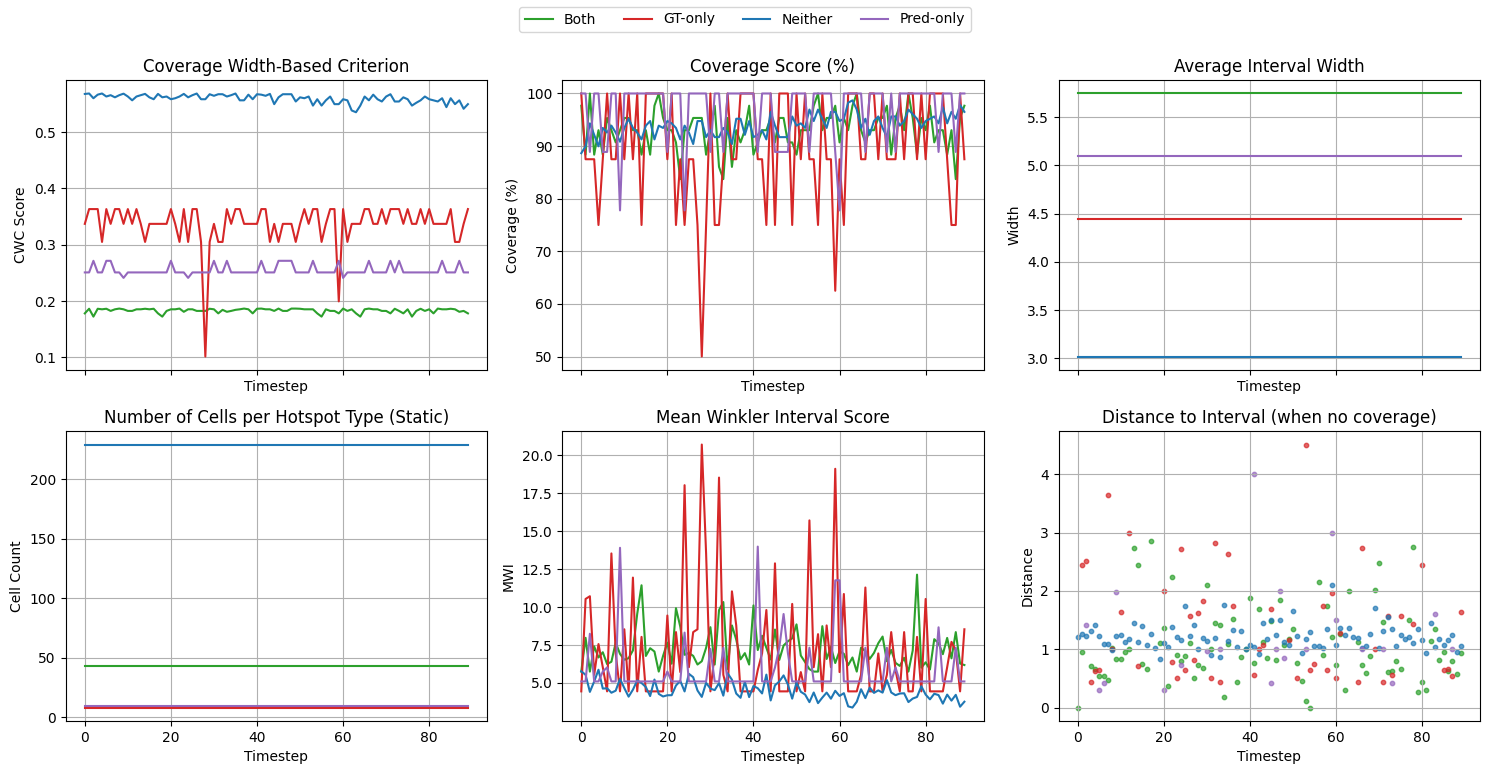

In [13]:
plot_temporal_metrics_over_time(
    result_cwc,
    coverage_results,
    width_results,
    result_mwi,
    error_results,
    mode="static",
    overall_hs_class_df=overall_hs_class_df,
    palette=palette
)


## 📊 Interval Width and Misscoverage by Hotspot Match Type

This section examines how **prediction interval width** and **misscoverage distance** vary depending on the **hotspot classification** and whether the prediction was correct (i.e., the true value falls inside the interval).

### 🔍 Analysis Breakdown

Two complementary plots are generated using the merged dataset:

---

### 1️⃣ Boxenplot + Histogram (per hotspot type)

This combined figure is divided vertically into two axes:

- **Top**: A `boxenplot` showing the distribution of **interval width** (`Width`) for each **coverage status** (`Yes`/`No`), further split by **hotspot match type** (`GT-only`, `Pred-only`, `Both`, `Neither`).
  
- **Bottom**: A stacked `histplot` of **distance to the interval** (`Distance to interval`) **when the coverage fails**. This helps assess how far off the predictions are when the model fails to cover the actual count, again stratified by hotspot type.

> ✅ This combined view allows us to assess both how wide the intervals are and how severe the errors are when predictions miss.

---

### 2️⃣ Joint KDE Plot: Width vs Coverage Score

This 2D density plot shows the relationship between:

- **X-axis**: Interval width
- **Y-axis**: Coverage score (in %)
- **Hue**: Hotspot match type

Using `JointGrid`, we overlay **kernel density estimates (KDEs)** to reveal how the hotspot classification affects this trade-off.

> 🧠 This plot helps reveal regimes where wider intervals tend to improve coverage — or where certain hotspot types consistently suffer from undercoverage despite wide intervals.

---

### 📌 Notes

- Only **cells with known beat** are considered.
- Coverage is converted to `"Yes"`/`"No"` and used for splitting the boxen/hist plots.
- The KDE plots use unfilled contours for clarity, with marginal densities plotted above and to the right.
- All colors and legend orders are consistent across figures (`palette`, `hue_order`).

These visualizations help determine whether certain hotspot categories are more prone to uncertainty and how that uncertainty is manifested spatially and statistically.

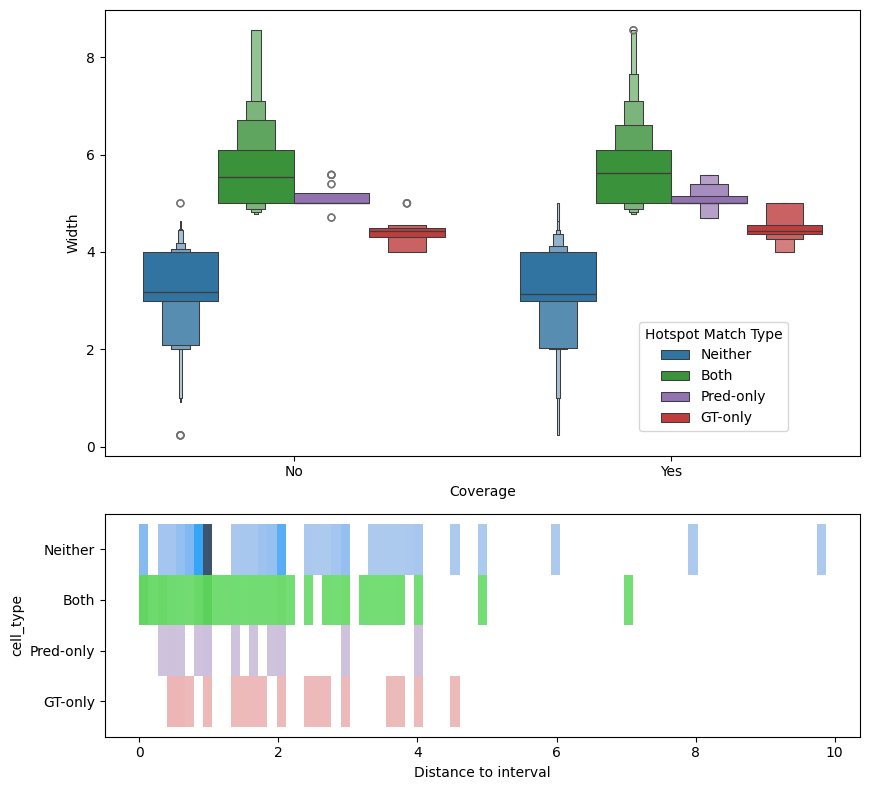

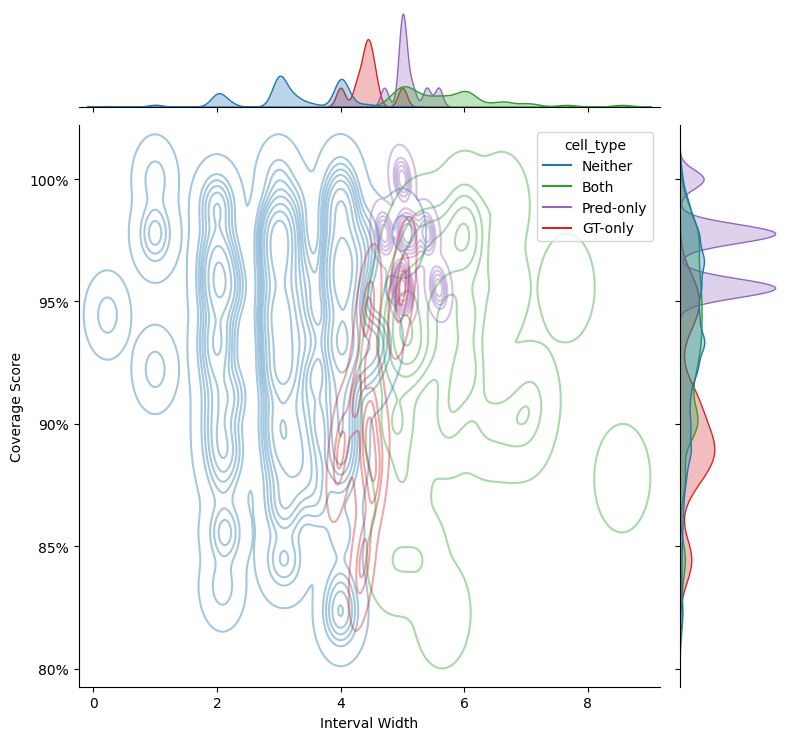

In [14]:
hue_order = ["Neither", "Both", "Pred-only", "GT-only"]

# Prepare plotting DataFrame
df_plot = df_metrics.merge(overall_hs_class_df,on=["row","col","beat"]).dropna(subset="beat")

# Main plot: Boxenplot + stacked histogram
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=False, gridspec_kw={"height_ratios": [2, 1]})

# Boxenplot: Interval width per coverage and hotspot type
sns.boxenplot(
    data=df_plot,
    x="Coverage", y="Width",
    hue="cell_type",
    palette=palette,
    hue_order=hue_order,
    ax=ax1
)
# ax1.set_title("Interval Width by Coverage and Hotspot Type")
ax1.legend_.remove()

# Histogram: Distance when outside interval
df_errors = df_plot[df_plot["Coverage"] == "No"].copy()
df_errors["cell_type"] = pd.Categorical(df_errors["cell_type"], categories=hue_order, ordered=True)

sns.histplot(
    df_errors,
    y="cell_type",
    x="Distance to interval",
    hue="cell_type",
    ax=ax2,
    legend=False,
    hue_order=hue_order,
    palette=palette,
)

# Shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title="Hotspot Match Type", bbox_to_anchor=(0.8, 0.6), frameon=True)

plt.tight_layout(rect=[0, 0, 0.88, 1])
# fig.savefig("../../results/figures/interval_width_by_match.pdf", format="pdf", bbox_inches="tight", dpi=300)
# fig.savefig("../../results/figures/interval_width_by_match.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# --- Joint KDE Plot: Misscoverage vs. Interval Width
g = sns.JointGrid(
    data=df_plot,
    x="Width",
    y="Coverage Score",
    hue="cell_type",
    palette=palette,
    hue_order=hue_order,
    height=8
)

g.plot_joint(sns.kdeplot, fill=False, alpha=0.4, thresh=0.005)
g.plot_marginals(sns.kdeplot, common_norm=False, fill=True, alpha=0.3)
g.ax_joint.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
# g.figure.suptitle("Misscoverage vs. Interval Width by Hotspot Type", fontsize=14)
g.set_axis_labels("Interval Width", "Coverage Score")
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.92)
# g.savefig("../../results/figures/2d_interval_width_by_match.pdf", format="pdf", bbox_inches="tight", dpi=300)
# g.savefig("../../results/figures/2d_interval_width_by_match.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

## ⏱️ Temporal Hotspot Classification (Dynamic)

Unlike the static approach, which aggregates hotspot classification across the entire time window, this section analyzes **hotspot types at each timestep** to reflect their dynamic nature.

### 🔄 Per-Timestep Evaluation

The classification grid `time_step_hs_class_grid` assigns a **cell type label** to each spatial unit `(row, col)` for every **timestep**. The categories include:

- **GT-only**: Cells in the ground-truth hotspot, but not predicted.
- **Pred-only**: Cells predicted as hotspot, but not in ground-truth.
- **Both**: Correct predictions (true positive hotspots).
- **Neither**: Non-hotspot areas (true negatives).

In [15]:
unique, counts = np.unique(time_step_hs_class_grid, return_counts=True)
pd.DataFrame( {"Cell Type": unique,"Counts":counts})

,Cell Type,Counts
0,Both,1240
1,GT-only,1430
2,Neither,19900
3,Pred-only,3440


## 🗺️ Dynamic Hotspot Classification Maps

To understand how the hotspot classification evolves **over time**, we sample and visualize 4 random timesteps from the `time_step_hs_class_grid`.

### 🧭 What is being visualized?

For each selected day:
- The cells are classified into one of four categories:  
  - **GT-only**: In the true hotspot, not predicted  
  - **Pred-only**: Predicted as hotspot, not in ground truth  
  - **Both**: Correctly predicted hotspots  
  - **Neither**: Non-hotspot cells  
- Each cell is colored according to its type using a consistent `palette`.

These classifications are merged with the **Chicago Police Beats** geometry to generate spatial maps.

### 🔄 Visualization Strategy

- We randomly select 4 timesteps.
- Each map displays the hotspot classification for one day.
- A **single legend** is added on the first plot for clarity.

### 🔍 Interpretation

This view provides insight into:
- The variability of hotspot predictions and ground truth over time.
- Spatial stability or drift in hotspot patterns.
- Systematic biases in under- or over-prediction.

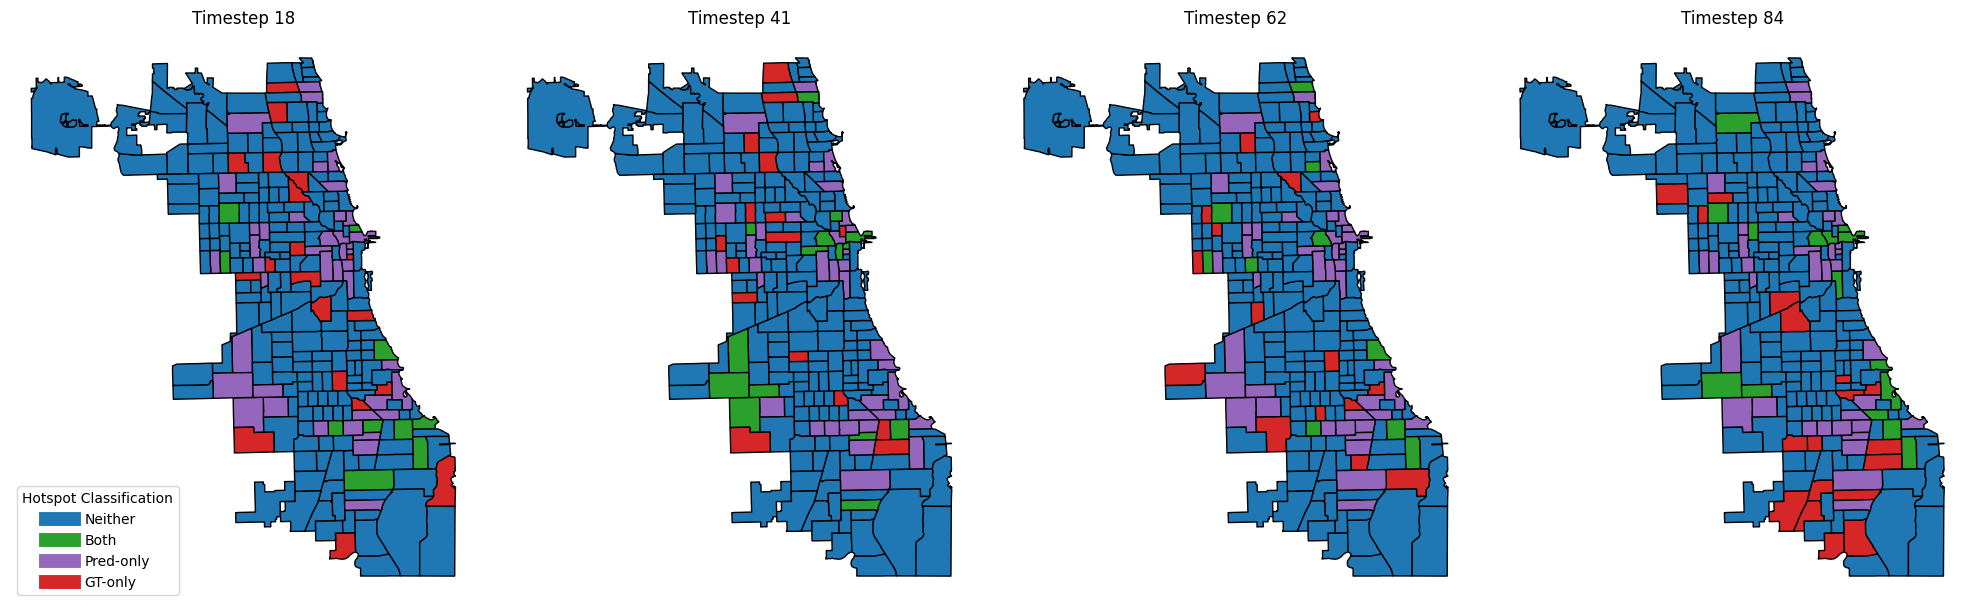

In [16]:
time_step_hs_class_df = grid_to_dataframe(time_step_hs_class_grid, coord_to_beat_map, value_name="cell_type").set_index(["timestep","row","col","beat"]).reset_index()

# Sample 4 random timesteps
random_times = sorted(np.random.choice(time_step_hs_class_df["timestep"].unique(), 4, replace=False))

# Create 1 row x 4 columns figure
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, time in enumerate(random_times):
    ax = axes[i]

    # Merge classification for selected timestep
    merged = gdf.merge(
        time_step_hs_class_df[time_step_hs_class_df["timestep"] == time],
        how="left",
        left_on="beat_num",
        right_on="beat"
    ).dropna(subset=["cell_type"])

    merged["color"] = merged["cell_type"].map(palette)

    # Plot
    merged.plot(color=merged["color"], edgecolor="black", ax=ax)
    ax.set_title(f"Timestep {time}", fontsize=12)
    ax.set_axis_off()

# Add a single legend on the first axis
handles = [plt.Line2D([0], [0], color=color, linewidth=10) for label, color in palette.items()]
labels = list(palette.keys())
axes[0].legend(handles, labels, title="Hotspot Classification", loc="lower left", frameon=True, fontsize=10)

# fig.suptitle("Hotspot Cell Classification Over Time", fontsize=16)
plt.tight_layout()
plt.show()

## 📊 Radar Chart of Uncertainty Metrics by Hotspot Type (Dynamic)

This section evaluates and compares multiple uncertainty metrics across hotspot types, using **dynamic hotspot classification** (i.e., computed day-by-day and then aggregated).

### 📐 Metrics Evaluated:
The following metrics are summarized and plotted per hotspot type:

- **Coverage Score**: Fraction of times the true value fell within the interval.
- **Interval Width Score**: Average width of the prediction interval.
- **Distance to Interval (when no cover)**: Error when the interval fails to contain the true value.
- **Mean Winkler Interval Score**: Penalized score for prediction interval quality.
- **Coverage Width-Based Criterion (CWC)**: A joint measure of coverage and width.

### 🌀 Visualization Approach:
Each metric is plotted as a **radar chart**, where:
- Each axis corresponds to a hotspot type (`GT-only`, `Pred-only`, `Both`, `Neither`).
- The shape of the polygon reveals which types are better or worse in each metric.
- This comparison helps diagnose **biases or weaknesses** in the model's uncertainty estimation.

### 🧾 Tabular Summary:
Beneath the radar plots, a unified **summary table** is printed showing the exact per-type values for all five metrics. This facilitates quantitative comparison beyond the visual shapes.

### ⚙️ Parameters:
- `static=False`: Indicates this analysis uses **dynamic cell classification**.
- `metric_limits`: Y-axis bounds are explicitly defined for consistency across charts.
- `show_tables=True`: Enables display of tabular summaries.

This view is useful for diagnosing whether prediction quality varies depending on **temporal alignment** between predicted and observed hotspots.

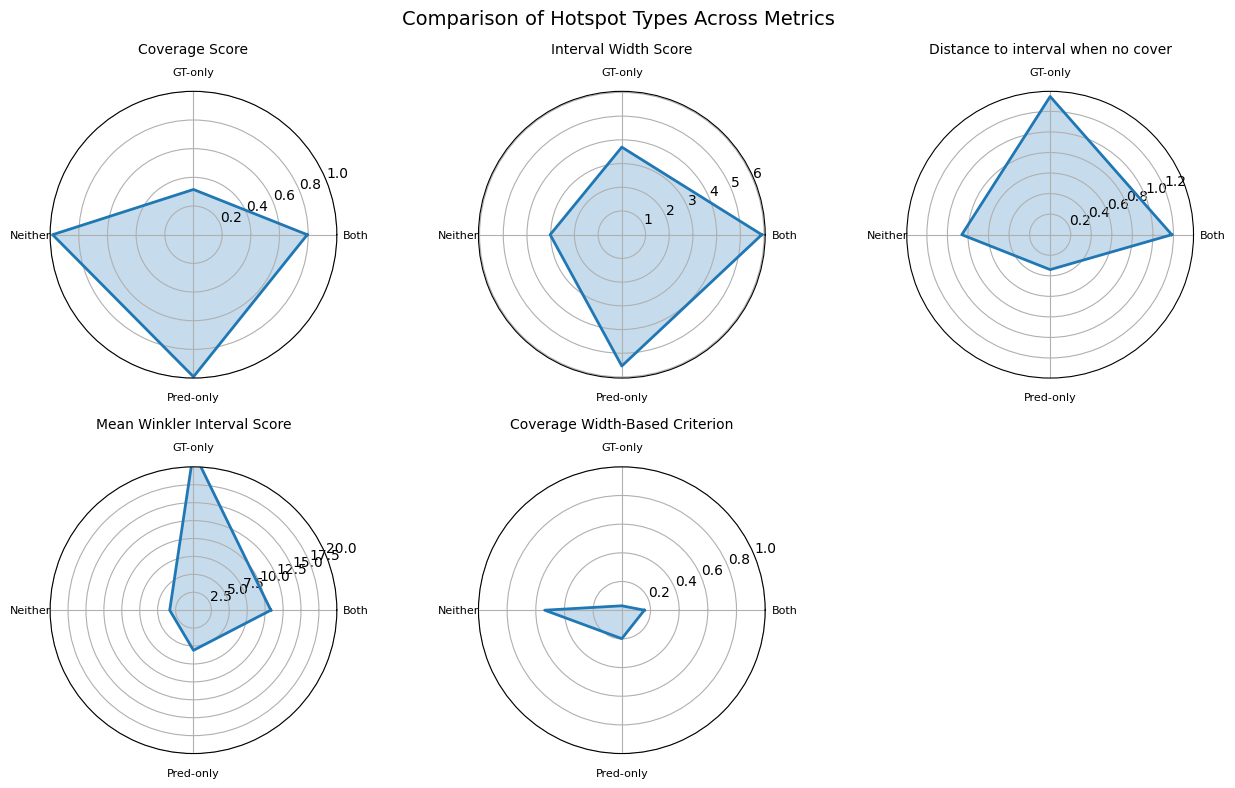

,Coverage Score,Interval Width Score,Distance to interval when no cover,Mean Winkler Interval Score,Coverage Width-Based Criterion
Both,0.793548,5.902456,1.183744,10.790173,0.157004
GT-only,0.315385,3.693120,1.345159,22.111452,0.030681
Neither,0.982814,3.022375,0.860237,3.318055,0.537896
Pred-only,0.990988,5.537701,0.339928,5.598967,0.198505


In [18]:
R=plot_metric_radar_by_hotspot_type(
    results_list=[coverage_results, width_results, error_results, result_mwi, result_cwc],
    metric_names=[
        "Coverage Score",
        "Interval Width Score",
        "Distance to interval when no cover",
        "Mean Winkler Interval Score",
        "Coverage Width-Based Criterion"
    ],
    static=False,
    metric_limits={
        "Coverage Score": (0.0, 1.0),
        "Interval Width Score": (0.0, None),
        "Distance to interval when no cover": (0.0, None), 
        "Mean Winkler Interval Score": (0.0, 20.0),
        "Coverage Width-Based Criterion": (0.0, 1.0)},
    show_tables=True
)


## 📈 Temporal Behavior of Uncertainty Metrics (Dynamic Hotspot Classification)

This section analyzes how uncertainty metrics evolve **over time**, using **dynamic hotspot classification**. That is, hotspots are re-evaluated at each timestep to reflect changing spatial crime patterns.

### 📊 Metrics Tracked:
The following group-level metrics are computed and visualized per timestep, stratified by hotspot type:

1. **Coverage Width-Based Criterion (CWC)**: Balances interval width and empirical coverage.
2. **Coverage Score (%)**: Fraction of covered values.
3. **Interval Width**: Average width of prediction intervals.
4. **Number of Cells per Type**: Shows the count of cells per hotspot category (dynamic classification).
5. **Mean Winkler Interval Score (MWI)**: Penalizes both over- and under-coverage.
6. **Distance to Interval** (when miscoverage occurs): Magnitude of error when the true value is not covered.

### 📐 Visualization Layout:
A 2-row × 3-column subplot grid is used to display the six metrics in a compact and interpretable format. All subplots share the x-axis (timesteps), enabling synchronized trend interpretation.

### 🧭 Dynamic Classification:
The number of cells per hotspot type **changes over time** in dynamic mode. This allows us to observe:
- How the model performs under shifting hotspot definitions.
- Whether any hotspot type becomes harder to predict or calibrate.

### ⚙️ Parameters:
- `mode="dynamic"`: Activates time-varying hotspot classification.
- `time_step_hs_class_df`: DataFrame containing per-timestep hotspot cell classifications.
- `palette`: Custom color mapping for cell types (`GT-only`, `Pred-only`, `Both`, `Neither`).

This view is critical to assess the **temporal consistency** of the model’s uncertainty calibration and to identify moments of underperformance or structural drift.

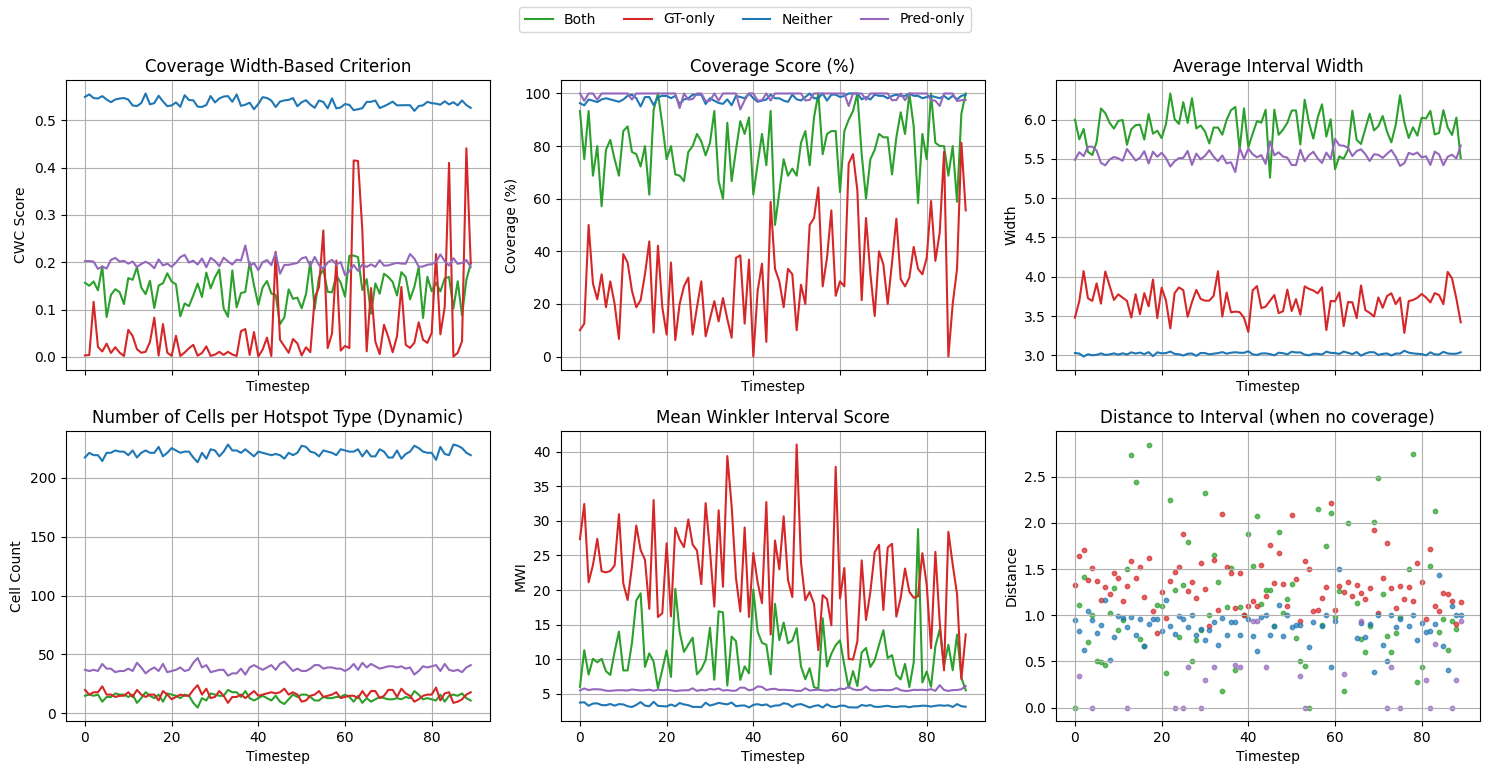

In [19]:
plot_temporal_metrics_over_time(
    result_cwc,
    coverage_results,
    width_results,
    result_mwi,
    error_results,
    mode="dynamic",
    time_step_hs_class_df=time_step_hs_class_df,
    palette=palette
)

## 📊 Error Analysis by Hotspot Type (Dynamic)

This section analyzes how the **performance of uncertainty quantification varies across hotspot types**, based on a dynamic (per-timestep) classification.

### 🔍 What We Analyze

For each cell and timestep, we examine:

1. **Interval Width vs Coverage** per hotspot type
2. **Error Distance** when miscoverage occurs
3. **Joint Distribution** of Width and Coverage Score, stratified by hotspot classification

This helps identify whether some types of hotspot mismatches (e.g., false positives or false negatives) are more prone to uncertainty calibration issues.

---

### 📦 1. Interval Width Distribution by Coverage and Hotspot Type

- A **boxenplot** shows the distribution of interval widths for:
  - Covered vs Not Covered predictions
  - Stratified by cell type: `GT-only`, `Pred-only`, `Both`, `Neither`
- Reveals whether the model produces wider intervals for certain types.

### 📉 2. Histogram of Distance to Interval (Only for Miscovered Points)

- A **stacked histogram** shows the error magnitude (distance to interval) when the true count is outside the prediction interval.
- Stratified by hotspot type.
- Helps identify if specific misclassified hotspot types yield **systematically worse errors**.

---

### 🔬 3. Joint KDE Plot: Coverage Score vs Interval Width

- Shows the **density of cell-time observations** over Coverage Score and Interval Width.
- Stratified by hotspot type.
- Useful to detect overlap, separation, or trade-offs in calibration across classes.

---

### 🎨 Plotting Notes

- Color palette is consistent across all visualizations for clarity.
- `hue_order` ensures consistent legend and color assignment: `["Neither", "Both", "Pred-only", "GT-only"]`.
- Legends are unified and placed outside the plots for compactness.

These visualizations provide **granular insight** into how prediction intervals behave under complex classification dynamics, and support interpretation of potential **bias or limitations** in the conformal calibration process across hotspot categories.

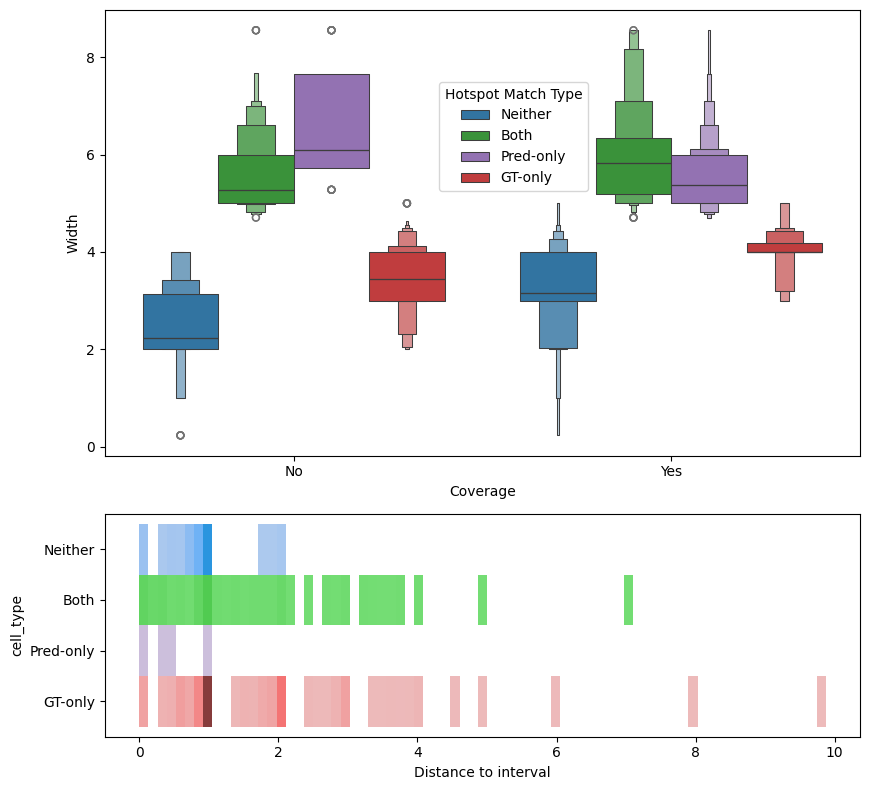

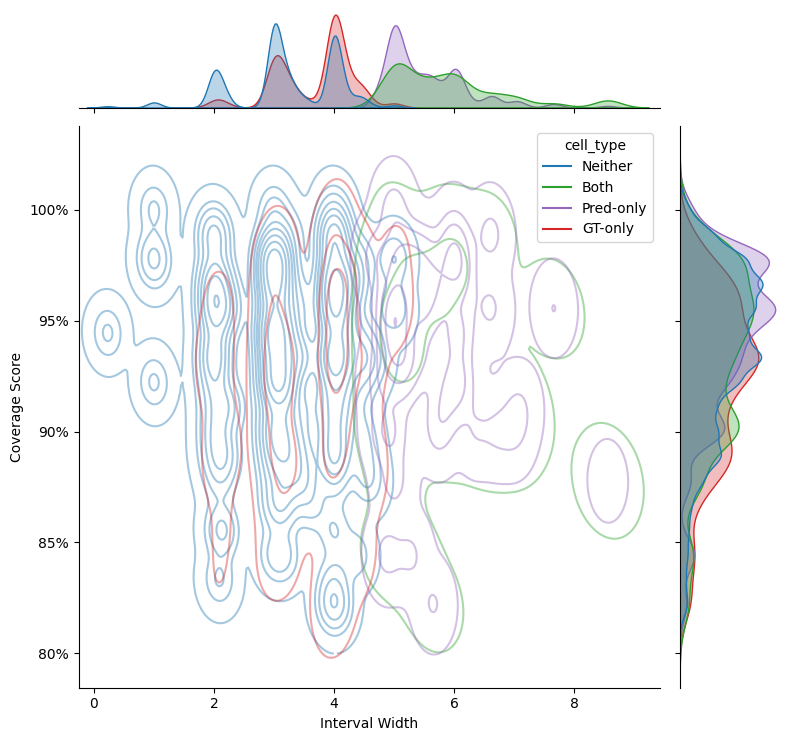

In [20]:
hue_order = ["Neither", "Both", "Pred-only", "GT-only"]

# Prepare plotting DataFrame
df_plot = df_metrics.merge(time_step_hs_class_df,on=["timestep","row","col","beat"]).dropna(subset="beat")

# Main plot: Boxenplot + stacked histogram
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=False, gridspec_kw={"height_ratios": [2, 1]})

# Boxenplot: Interval width per coverage and hotspot type
sns.boxenplot(
    data=df_plot,
    x="Coverage", y="Width",
    hue="cell_type",
    palette=palette,
    hue_order=hue_order,
    ax=ax1
)
# ax1.set_title("Interval Width by Coverage and Hotspot Type")
ax1.legend_.remove()

# Histogram: Distance when outside interval
df_errors = df_plot[df_plot["Coverage"] == "No"].copy()
df_errors["cell_type"] = pd.Categorical(df_errors["cell_type"], categories=hue_order, ordered=True)

sns.histplot(
    df_errors,
    y="cell_type",
    x="Distance to interval",
    hue="cell_type",
    ax=ax2,
    legend=False,
    hue_order=hue_order,
    palette=palette,
)

# Shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title="Hotspot Match Type", bbox_to_anchor=(0.6, 0.9), frameon=True)

plt.tight_layout(rect=[0, 0, 0.88, 1])
# fig.savefig("../../results/figures/interval_width_by_match.pdf", format="pdf", bbox_inches="tight", dpi=300)
# fig.savefig("../../results/figures/interval_width_by_match.png", format="png", bbox_inches="tight", dpi=300)
plt.show()

# --- Joint KDE Plot: Misscoverage vs. Interval Width
g = sns.JointGrid(
    data=df_plot,
    x="Width",
    y="Coverage Score",
    hue="cell_type",
    palette=palette,
    hue_order=hue_order,
    height=8
)

g.plot_joint(sns.kdeplot, fill=False, alpha=0.4, thresh=0.005)
g.plot_marginals(sns.kdeplot, common_norm=False, fill=True, alpha=0.3)
g.ax_joint.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
# g.figure.suptitle("Misscoverage vs. Interval Width by Hotspot Type", fontsize=14)
g.set_axis_labels("Interval Width", "Coverage Score")
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.92)
# g.savefig("../../results/figures/2d_interval_width_by_match.pdf", format="pdf", bbox_inches="tight", dpi=300)
# g.savefig("../../results/figures/2d_interval_width_by_match.png", format="png", bbox_inches="tight", dpi=300)
plt.show()